C:\Users\Arno\AppData\Local\Temp/ipykernel_22432/2407764298.py:5: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
C:\Users\Arno\AppData\Local\Temp/ipykernel_22432/2407764298.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


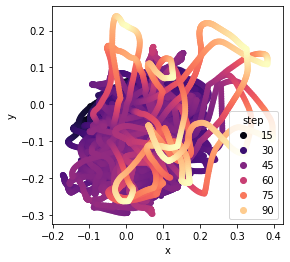

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
import pandas as pd
import datetime


anomaly = "qtran__2022-09-09_11-22-30_668"

indi_pos = "qtran__2022-09-09_11-49-19_1"

obvious = "qtran__2022-09-09_12-09-12_908"

normal = "qtran__2022-09-09_19-52-13_391"

indi_pos1 = "qtran__2022-09-10_11-22-09_553"

test = "qtran__2022-09-15_15-57-15_973"

dir_name = "AA-2015"


env_name = "3s_vs_3z"

save_path = os.path.join(os.getcwd(), "results", "models", "custom", env_name, dir_name)

plt.gca().set_aspect('equal', adjustable='box')

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

with open(os.path.join(save_path, "pro_pos.npy"), "rb") as pro_pos_f:
    fsz = os.fstat(pro_pos_f.fileno()).st_size
    pro_pos = np.load(pro_pos_f)
    while pro_pos_f.tell() < fsz:
        pro_pos = np.vstack((pro_pos, np.load(pro_pos_f)))
    pro_x = pro_pos[:, 0]
    pro_y = pro_pos[:, 1]
    pro_step = pro_pos[:, 2]

    pro_x = moving_average(pro_x, n=100)
    pro_y = moving_average(pro_y, n=100)
    pro_step = moving_average(pro_step, n=100)

    df_pro = pd.DataFrame()
    df_pro["x"] = pro_x
    df_pro["y"] = pro_y
    df_pro["step"] = pro_step

    df_pro.sort_values('step', inplace=True)

with open(os.path.join(save_path, "ant_pos.npy"), "rb") as ant_pos_f:
    fsz = os.fstat(ant_pos_f.fileno()).st_size
    ant_pos = np.load(ant_pos_f)
    while ant_pos_f.tell() < fsz:
        ant_pos = np.vstack((ant_pos, np.load(ant_pos_f)))
    ant_x = ant_pos[:, 0]
    ant_y = ant_pos[:, 1]
    ant_step = ant_pos[:, 2]

    ant_x = moving_average(ant_x, n=100)
    ant_y = moving_average(ant_y, n=100)
    ant_step = moving_average(ant_step, n=100)

    df_ant = pd.DataFrame()
    df_ant["x"] = ant_x
    df_ant["y"] = ant_y
    df_ant["step"] = ant_step

    df_ant.sort_values('step', inplace=True)



magma = sns.color_palette("magma", as_cmap=True)

plt = sns.scatterplot(x="x", y="y", data=df_pro, hue="step", linewidth=0, palette=magma, marker="o")
# plt = sns.scatterplot(x="x", y="y", data=df_ant, hue="step", linewidth=0, palette=magma, marker="o")

fig = plt.get_figure()

fig.show()


# timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# plot_dir = os.path.join(os.getcwd(), 'plots')
# if not os.path.exists(plot_dir):
#     os.makedirs(plot_dir)
# fig.savefig(os.path.join(plot_dir, '{}_pos_{}.png'.format("label", timestamp)), dpi=300, bbox_inches="tight")
# fig.clf()






In [ ]:






def plot_coords(x, y, s):
    fig, ax = plt.subplots()
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=500, density=True)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
    plt.gca().set_aspect('equal', adjustable='box')
    return plt, fig

def select_first(x, y, steps, max):
    x = np.array([x[x_i] for x_i in range(len(x)) if steps[x_i] < max])
    y = np.array([y[y_i] for y_i in range(len(y)) if steps[y_i] < max])
    steps = np.array([steps[steps_i] for steps_i in range(len(steps)) if steps[steps_i] < max])
    return x, y, steps

def add_corners(x, y, steps):
    x = list(x)
    y = list(y)
    steps = list(steps)
    x.append(-0.5)
    x.append(0.5)
    y.append(-0.5)
    y.append(0.5)
    steps.append(0)
    steps.append(0)
    x = np.array(x)
    y = np.array(y)
    steps = np.array(steps)
    return x, y, steps

def plot_sns_hist(x, y, steps, s):
    df = pd.DataFrame({"x": x, "y": y, "step": steps})

    color = sns.color_palette("coolwarm", as_cmap=True)

    norm = plt.Normalize(df['step'].min(), df['step'].max())
    sm = plt.cm.ScalarMappable(cmap = color, norm=norm)
    sm.set_array([])

    hist = sns.histplot(df, x="x", y="y", hue="step", bins=s, pthresh=.0002, palette=color)
    hist.get_legend().remove()
    hist.figure.colorbar(sm)

    hist.patch.set_alpha(0)
    fig = hist.get_figure()
    return fig

def save_plot(label, fig):
    timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    plot_dir = os.path.join(os.getcwd(), 'plots')
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    fig.savefig(os.path.join(plot_dir, '{}_pos_{}.png'.format(label, timestamp)), dpi=300, bbox_inches="tight")
    fig.clf()

# s = 16
# max_step = 75
#
#
# ant_x, ant_y, ant_step = add_corners(ant_x, ant_y, ant_step)
# pro_x, pro_y, pro_step = add_corners(pro_x, pro_y, pro_step)
#
# ant_x, ant_y, ant_step = select_first(ant_x, ant_y, ant_step, max_step)
# pro_x, pro_y, pro_step = select_first(pro_x, pro_y, pro_step, max_step)
#
# # ant_plt, ant_fig = plot_coords(ant_x, ant_y, s)
# # ant_fig.savefig(os.path.join(save_path, "antagonist_pos.png"), dpi=300, bbox_inches="tight")
# # ant_plt.show()
# # ant_fig.clf()
# #
# # pro_plt, pro_fig = plot_coords(pro_x, pro_y, s)
# # pro_fig.savefig(os.path.join(save_path, "protagonist_pos.png"), dpi=300, bbox_inches="tight")
# # pro_plt.show()
# # pro_fig.clf()
#
# label_pro = "protagonist"
# label_ant = "antagonist"
#
# fig = plot_sns_hist(ant_x, ant_y, ant_step, s)
# save_plot(label_ant, fig)
# fig = plot_sns_hist(pro_x, pro_y, pro_step, s)
# save_plot(label_pro, fig)

